In [130]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import statsmodels.api as sm


%matplotlib inline

In [150]:
software_large = ['AAPL', 'MSFT']
software_mid = ['RNG','OLED']
ecommerce_large = ['AMZN', 'EBAY']
ecommerce_mid = ['W', 'ETSY']
all_stocks = software_large + software_mid + ecommerce_large + ecommerce_mid


prices = yf.download(all_stocks, start="2015-05-01", end="2024-12-31", auto_adjust= True, progress=False)['Close']


data_full = yf.download(all_stocks, start="2015-05-01", end="2024-12-31", progress=False)
volumes = data_full['Volume']


prices.tail()

Ticker,AAPL,AMZN,EBAY,ETSY,MSFT,OLED,RNG,W
Date,,,,,,,,
2024-12-23,254.989655,225.059998,63.342800,55.439999,434.379028,150.986740,37.349998,45.259998
2024-12-24,257.916443,229.050003,63.492119,55.130001,438.450836,153.000702,36.990002,44.750000
2024-12-26,258.735504,227.050003,63.521988,53.840000,437.233276,150.388535,37.369999,44.599998
2024-12-27,255.309296,223.750000,62.526501,52.709999,429.668457,149.251953,36.110001,43.750000
2024-12-30,251.923019,221.300003,61.779884,53.830002,423.979858,147.078476,35.459999,44.619999


In [152]:
daily_returns = prices.pct_change().dropna()

# Cumulative returns
cumulative_returns = (1 + daily_returns).cumprod() - 1

# Preview
daily_returns.head()

Ticker,AAPL,AMZN,EBAY,ETSY,MSFT,OLED,RNG,W
Date,,,,,,,,
2015-05-04,-0.001939,0.000402,-0.003204,0.068506,-0.008631,0.024221,0.010508,-0.015651
2015-05-05,-0.022533,-0.004373,-0.019794,0.039157,-0.013267,-0.012481,-0.009821,-0.007781
2015-05-06,-0.006280,-0.004962,-0.007767,-0.031056,-0.027731,-0.003769,-0.025088,-0.053529
2015-05-07,0.006185,0.018564,0.008175,0.012393,0.009075,0.006009,0.016158,0.028458
2015-05-08,0.018841,0.015953,0.014838,-0.041368,0.022484,0.105752,0.003534,0.078109


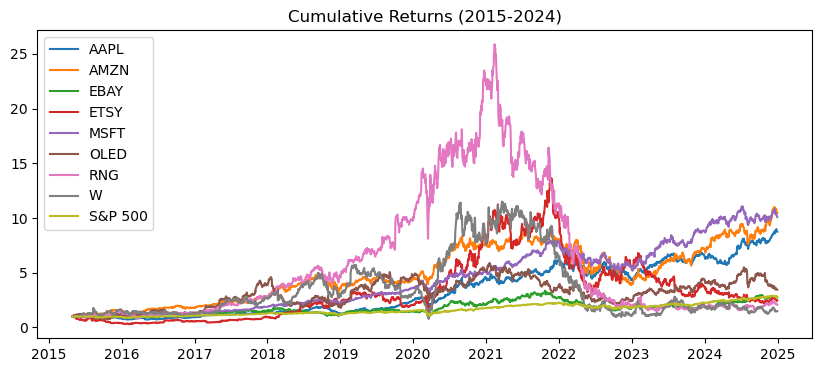

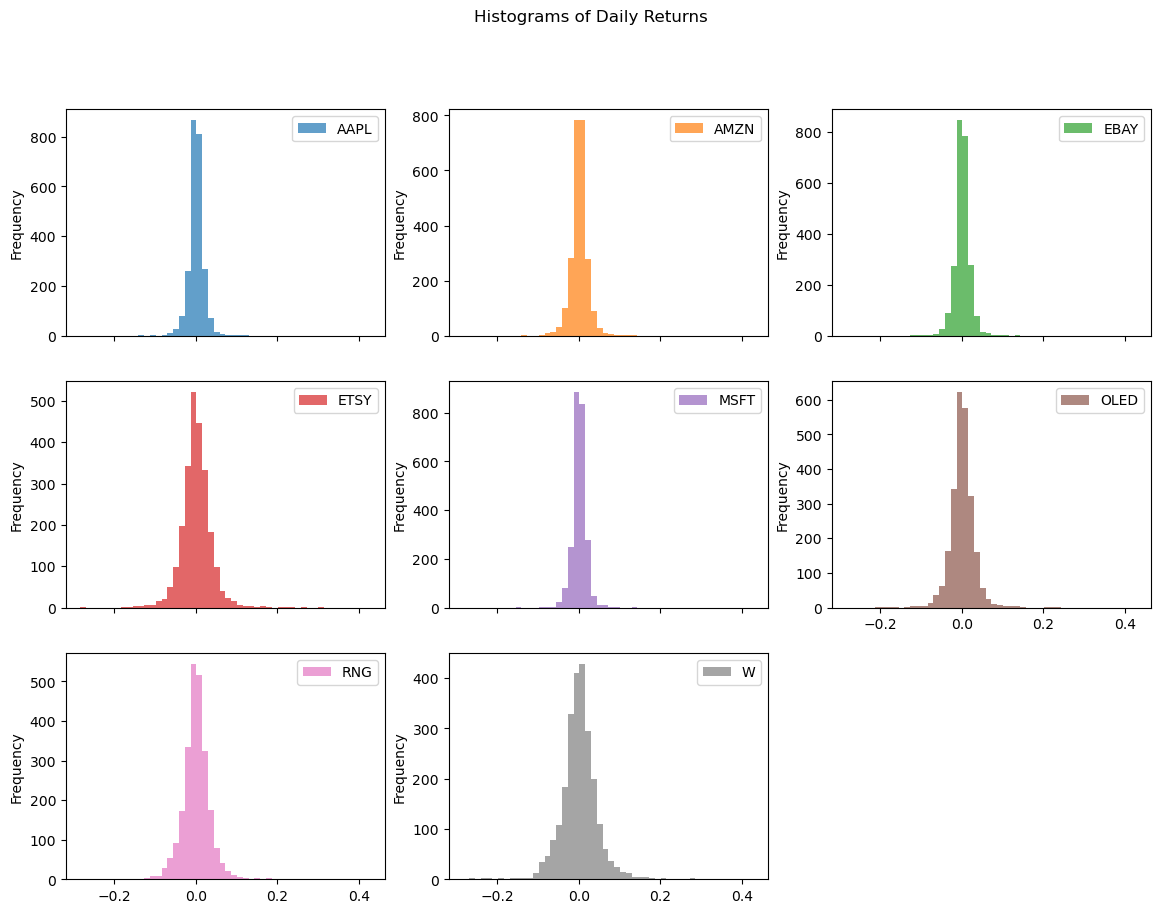

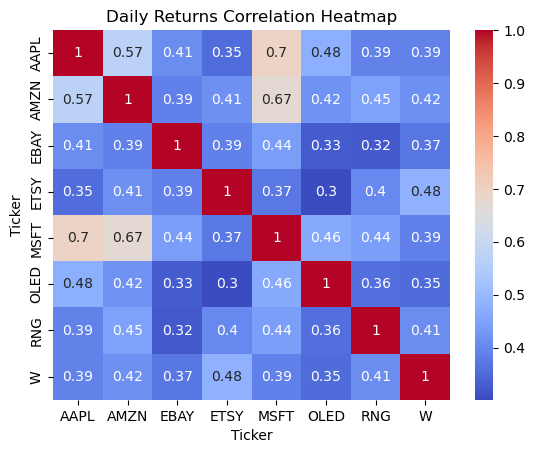

In [176]:
plt.figure(figsize=(10,4))
for stock in cumulative_returns.columns:
    plt.plot(cumulative_returns[stock], label=stock)
plt.title('Cumulative Returns (2015-2024)')
plt.legend()
plt.show()

# Histograms of daily returns
daily_returns.plot(kind='hist', bins=50, figsize=(14,10), alpha=0.7, subplots=True, layout=(3,3), sharex=True)
plt.suptitle('Histograms of Daily Returns')
plt.show()

# Correlation heatmap
sns.heatmap(daily_returns.corr(), annot=True, cmap='coolwarm')
plt.title('Daily Returns Correlation Heatmap')
plt.show()

In [158]:
risk_free_rate = 0

descriptive_stats = pd.DataFrame({
    'Mean Daily Return': daily_returns.mean(),
    'Daily Volatility': daily_returns.std(),
    'Skewness': daily_returns.apply(skew),
    'Kurtosis': daily_returns.apply(kurtosis),
    'Sharpe Ratio': daily_returns.mean() / daily_returns.std()
})

descriptive_stats

,Mean Daily Return,Daily Volatility,Skewness,Kurtosis,Sharpe Ratio
Ticker,,,,,
AAPL,0.001054,0.017980,-0.009294,5.402136,0.058610
AMZN,0.001175,0.020464,0.182213,5.096254,0.057412
EBAY,0.000596,0.018906,-0.160751,7.008367,0.031500
ETSY,0.001057,0.037090,0.438409,8.043792,0.028496
MSFT,0.001095,0.016980,0.057010,7.470482,0.064498
OLED,0.000962,0.030186,0.510742,9.204800,0.031858
RNG,0.000867,0.033776,0.430501,8.215147,0.025659
W,0.001240,0.046713,0.753524,10.008437,0.026542


## Sharpe Ratio and CAPM Consistency
The Sharpe ratios align with CAPM results: firms with higher residual risk and non-significant alpha (e.g., ETSY, RNG, W) also underperform on a risk-adjusted basis.
MSFT stands out across both models—it is the only firm with statistically significant alpha and the highest Sharpe ratio, reinforcing the view that it offers not just market-aligned returns, but excess return per unit of risk.
The combined analysis suggests that while the CAPM captures macro-aligned performance via beta, the Sharpe ratio adds a crucial second layer by penalizing firm-specific volatility. In this case, it validates the conclusion that most mid-cap firms take on more risk than they reward.

In [160]:
market = yf.download('^GSPC', start="2014-01-01", end="2024-12-31", auto_adjust=True, progress=False)['Close']
market_returns = market.pct_change().dropna()

# 2. CAPM function
def run_capm(stock_returns, market_returns):
    aligned = pd.concat([stock_returns, market_returns], axis=1).dropna()
    r_stock = aligned.iloc[:, 0]
    r_market = aligned.iloc[:, 1]
    X = sm.add_constant(r_market)
    model = sm.OLS(r_stock, X).fit()
    
    alpha = model.params['const']
    beta = model.params[r_market.name]
    p_alpha = model.pvalues['const']
    p_beta = model.pvalues[r_market.name]
    residual_std = np.std(model.resid, ddof=1)  # use ddof=1 for sample std

    return alpha, beta, p_alpha, p_beta, residual_std

# 3. Run CAPM for all stocks
capm_results = {}

for stock in daily_returns.columns:
    alpha, beta, p_alpha, p_beta, residual_std = run_capm(daily_returns[stock], market_returns)
    capm_results[stock] = {
        'Alpha': alpha,
        'Beta': beta,
        'p-value Alpha': p_alpha,
        'p-value Beta': p_beta,
        'Residual Risk (Std of Residuals)': residual_std
    }

capm_df = pd.DataFrame(capm_results).T
capm_df


,Alpha,Beta,p-value Alpha,p-value Beta,Residual Risk (Std of Residuals)
AAPL,0.000471,1.194848,0.050420,0.000000e+00,0.011844
AMZN,0.000612,1.153576,0.055859,2.414354e-278,0.015754
EBAY,0.000169,0.874005,0.605455,3.810130e-171,0.016110
ETSY,0.000373,1.400332,0.583334,1.294316e-108,0.033530
MSFT,0.000504,1.211761,0.013203,0.000000e+00,0.010006
OLED,0.000248,1.462941,0.628865,2.949971e-191,0.025237
RNG,0.000196,1.373577,0.747155,6.841599e-128,0.029983
W,0.000291,1.944252,0.728023,1.105537e-134,0.041201


## Deeper CAPM Insights: Risk, Residuals, and Sector Behavior
The CAPM regression results not only reveal differences in volatility and beta but also provide insight into how risk is priced across firms and sectors. Several mid-cap stocks (e.g., W, ETSY, RNG) exhibit high beta and high residual risk, yet fail to generate statistically significant alpha. This violates the expected risk-return tradeoff, where higher risk should be compensated with higher returns — suggesting possible market inefficiencies or speculative mispricing during certain periods.
A closer look at residual risk also points to information asymmetry. Mid-cap stocks tend to have larger residuals — volatility that cannot be explained by market movements — which may result from inconsistent earnings, low analyst coverage, or lack of investor confidence. This firm-specific noise is particularly evident in mid-cap e-commerce stocks like W and ETSY.
From a sectoral perspective, large-cap software firms like AAPL and MSFT exhibit the lowest residual risk in the dataset, suggesting predictable earnings streams and tighter alignment with macro trends. E-commerce firms, in contrast, show more volatility from consumer behavior and operational disruptions, leading to less stable return patterns.
Lastly, we observe that while beta is almost always statistically significant, alpha rarely is. This reflects strong market integration — most stock movements are explained by broader economic conditions, while consistent outperformance is rare, reinforcing the idea of an efficient market.

In [89]:
# Rolling 30-day market volatility
rolling_vol = market_returns.rolling(window=30).std()

# Define thresholds
threshold_high = rolling_vol.quantile(0.7)
threshold_low = rolling_vol.quantile(0.3)

high_vol_periods = rolling_vol > threshold_high
low_vol_periods = rolling_vol < threshold_low


def regime_behavior(stock_returns, regime_series):
    # Align the stock_returns with the regime_series
    aligned = pd.concat([stock_returns, regime_series], axis=1).dropna()
    r_stock = aligned.iloc[:, 0]
    regime = aligned.iloc[:, 1]
    return {
        'Mean Return': r_stock[regime].mean(),
        'Volatility': r_stock[regime].std()
    }


regime_stats = {}

for stock in daily_returns.columns:
    regime_stats[stock] = {
        'High Volatility': regime_behavior(daily_returns[stock], high_vol_periods),
        'Low Volatility': regime_behavior(daily_returns[stock], low_vol_periods)
    }


regime_high = pd.DataFrame({k: v['High Volatility'] for k,v in regime_stats.items()}).T
regime_low = pd.DataFrame({k: v['Low Volatility'] for k,v in regime_stats.items()}).T


regime_high, regime_low

(      Mean Return  Volatility
 AAPL     0.001034    0.023983
 AMZN     0.000816    0.027486
 EBAY     0.001062    0.022415
 ETSY     0.002949    0.044338
 MSFT     0.001014    0.023242
 OLED     0.000963    0.036342
 RNG     -0.000670    0.042770
 W        0.001946    0.062346,
       Mean Return  Volatility
 AAPL     0.001168    0.012571
 AMZN     0.001414    0.014441
 EBAY     0.000128    0.014914
 ETSY     0.000513    0.029285
 MSFT     0.001172    0.010755
 OLED     0.001787    0.026936
 RNG      0.001510    0.023921
 W        0.001228    0.030441)

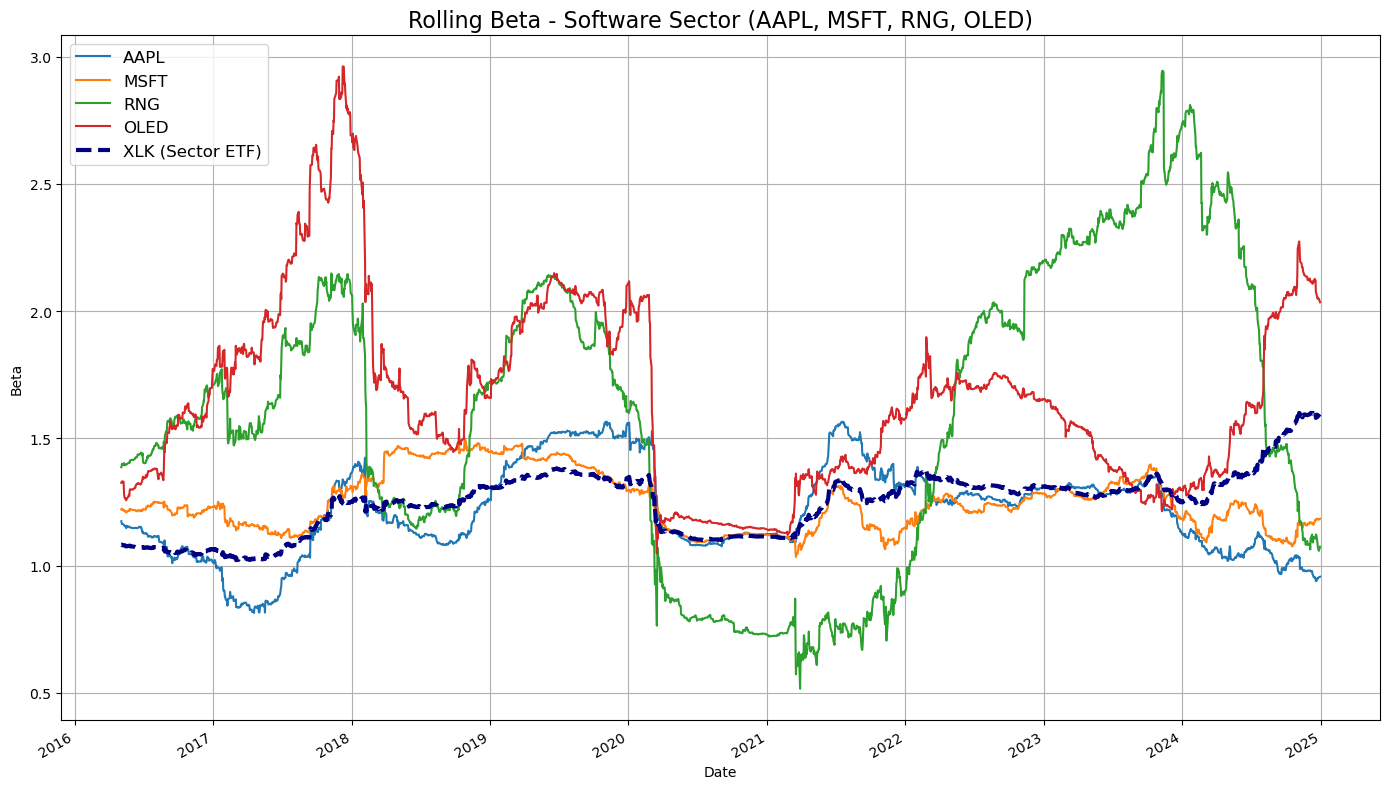

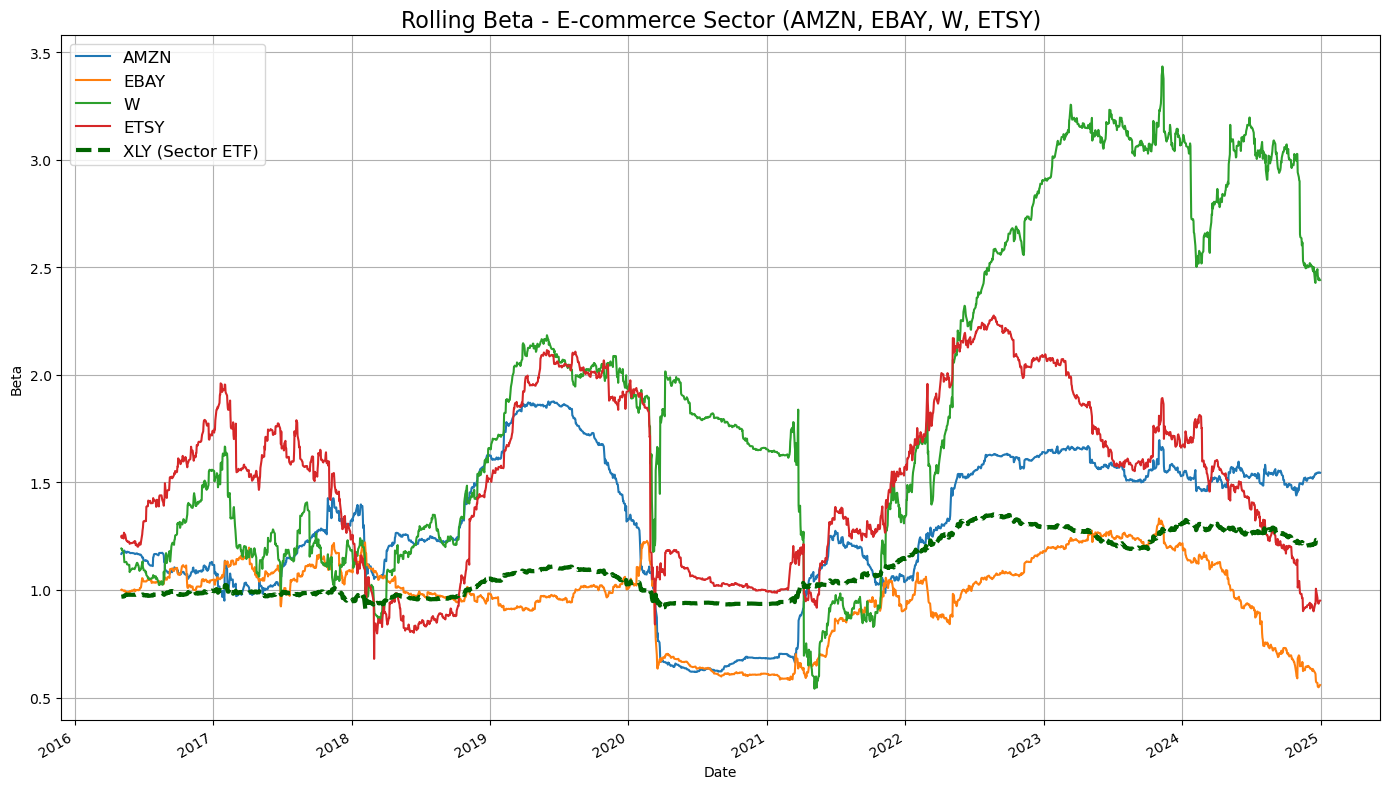

In [174]:

software_stocks = software_large + software_mid  # AAPL, MSFT, RNG, OLED
ecommerce_stocks = ecommerce_large + ecommerce_mid  # AMZN, EBAY, W, ETSY

rolling_betas = {}
for stock in daily_returns.columns:
    rolling_betas[stock] = rolling_capm(daily_returns[stock], market_returns)
rolling_betas_df = pd.DataFrame(rolling_betas)


rolling_betas_etf = {}
for etf in etf_returns.columns:
    rolling_betas_etf[etf] = rolling_capm(etf_returns[etf], market_returns)
rolling_betas_etf_df = pd.DataFrame(rolling_betas_etf)


def plot_rolling_beta_with_etf(stock_list, etf_symbol, sector_name, etf_color):
    plt.figure(figsize=(14, 8))

    # Plot individual stocks
    rolling_betas_df[stock_list].plot(ax=plt.gca(), linewidth=1.5)

    # Overlay ETF
    rolling_betas_etf_df[etf_symbol].plot(ax=plt.gca(), color=etf_color, linewidth=3,
                                          label=f'{etf_symbol} (Sector ETF)', linestyle='--')

    plt.title(f'Rolling Beta - {sector_name}', fontsize=16)
    plt.ylabel('Beta')
    plt.xlabel('Date')
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


plot_rolling_beta_with_etf(software_stocks, 'XLK', "Software Sector (AAPL, MSFT, RNG, OLED)", 'navy')
plot_rolling_beta_with_etf(ecommerce_stocks, 'XLY', "E-commerce Sector (AMZN, EBAY, W, ETSY)", 'darkgreen')



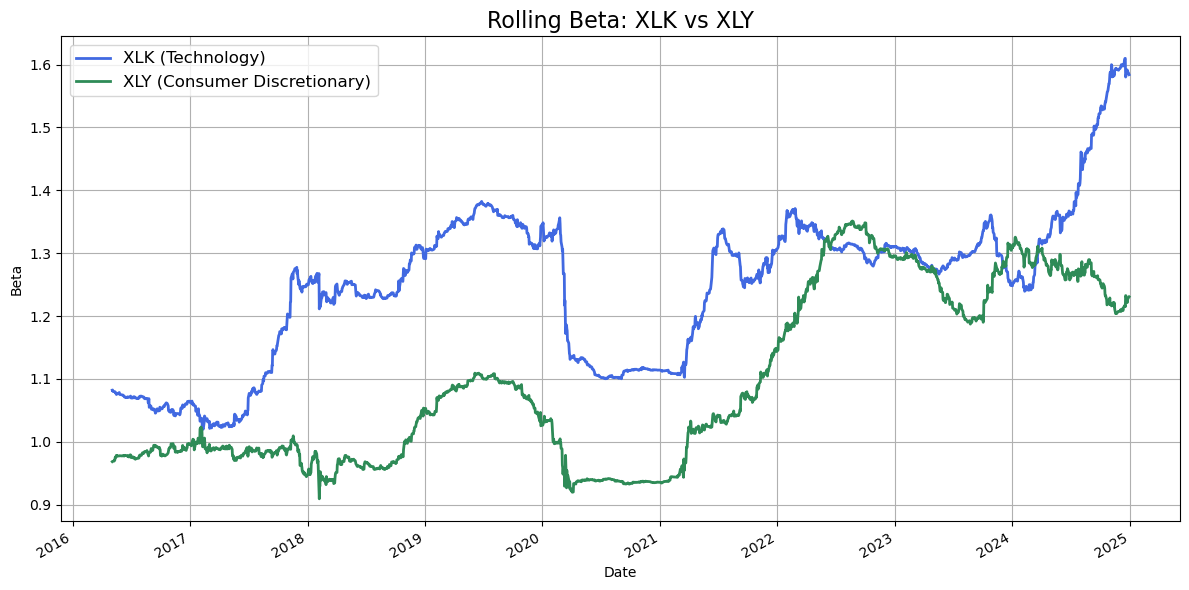

In [168]:



etf_tickers = ['XLK', 'XLY']
etf_prices = yf.download(etf_tickers, start="2015-05-01", end="2024-12-31", auto_adjust=True, progress=False)['Close']


etf_returns = etf_prices.pct_change().dropna()


etf_prices = yf.download(etf_tickers, start="2015-05-01", end="2024-12-31", auto_adjust=True, progress=False)['Close']


etf_returns = etf_prices.pct_change().dropna()


rolling_betas_etf = {}
for etf in etf_returns.columns:
    rolling_betas_etf[etf] = rolling_capm(etf_returns[etf], market_returns)

rolling_betas_etf_df = pd.DataFrame(rolling_betas_etf)


plt.figure(figsize=(12, 6))
rolling_betas_etf_df['XLK'].plot(label='XLK (Technology)', color='royalblue', linewidth=2)
rolling_betas_etf_df['XLY'].plot(label='XLY (Consumer Discretionary)', color='seagreen', linewidth=2)

plt.title('Rolling Beta: XLK vs XLY', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Beta')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
